<a href="https://colab.research.google.com/github/DMA2905/DMA_AI/blob/main/wvibxDA_user.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Schritt 1 - Vorbereitungen
Zuerst gilt es, die Softwarebibliotheken zu importieren, die wir benötigen, um unser Forecast-Modell zu bauen. Wir arbeiten hier mit PyTorch. Es macht Sinn, die importierte Version von PyTorch überprüfen, da es je nach Versionierung Unterschiede geben kann.

 Die jeweils aktuellste Version können Sie jederzeit auf PyTorch.org überprüfen:

https://pytorch.org/

In [ ]:
# Import der PyTorch Bibliotheken
import torch
from torch import nn

# Import visualization Bib
import matplotlib.pyplot as plt

# Überprüfen der PyTorch Versionierung
torch.__version__

'2.2.1+cu121'

##Schritt 2 - Datenbasis importieren und aufbereiten
Unsere Datenlage basiert auf Schokiverkäufen im vergangen Jahr. Die zur Verfügung stehenden Informationen bestehen aus:


*   Datum
*   Temperatur
*   Menge
*   Preis

Unser Forecast-Modell soll Mengen basierend auf der Temperaturveränderung vorhersagen.



In [ ]:
# Check to see if we have a GPU to use for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('A {} device was detected.'.format(device))

# Print the name of the cuda device, if detected
if device=='cuda':
    print (torch.cuda.get_dwevice_name (device=device))

A cpu device was detected.


In [ ]:
# Wir verwenden die pandas Bib um div. statistische Berechnungen druchzuführen
# Download Datenbasis
import pandas as pd
url = 'https://raw.githubusercontent.com/DMA2905/DMA_AI/main/dummy_data_test.csv'
df = pd.read_csv(url)

# Anzeigen der ersten 10 Zeilen
df.head(10)


,Datum,Menge,Temperatur,Sonnenschein,Sondereffekt,Wochenende,Sonderoeffnungszeit
0,02.01.2023,265,12,1,1,1,0
1,03.01.2023,60,8,0,0,0,0
2,04.01.2023,65,9,0,0,0,0
3,05.01.2023,265,12,1,1,0,0
4,09.01.2023,215,7,1,1,0,0
5,10.01.2023,55,7,0,0,0,0
6,11.01.2023,70,10,0,0,1,0
7,12.01.2023,120,10,1,0,1,0
8,13.01.2023,65,9,0,0,0,0
9,16.01.2023,80,6,1,0,0,0


In [ ]:
# Kurzes überprüfen der Struktur unseres Files
df.shape

(250, 7)

### CZuweisen von Input und Output Daten zur Erstellung unseres Forecasts

Wie oben gesehen, besteht die Datenbasis aus 7 Spalten:  

<pre> Datum, Menge, Temparatur, Sonnenschein, Sondereffekt, Wochenende, Sonderöffnungszeit</pre>

Idealer Weise wird ein neuronales Netwerk auf basis von einer Range -1 bis 1 trainiert. Unsere Spalte 'Menge' hingegen enthält eine breite Ausprägung von Merkmalen. Mittels Standardisierung werden wir daher unsere Daten in ein Brauchbares Format umwandeln.

In [ ]:
# Berechnen des Mittels und der Standardabweichung
# Standardisieren der Menge numMenge

numMengeMean = df["Menge"].mean()
numMengeStd = df["Menge"].std()
df['Menge'] = (df['Menge']-numMengeMean)/numMengeStd

# Standardisieren der Temparatur numTemp
numTempMean = df["Temperatur"].mean()
numTempStd = df["Temperatur"].std()
df['Temperatur'] = (df['Temperatur']-numTempMean)/numTempStd


In [ ]:
df.head(10)

,Datum,Menge,Temperatur,Sonnenschein,Sondereffekt,Wochenende,Sonderoeffnungszeit
0,02.01.2023,1.496672,-0.126648,1,1,1,0
1,03.01.2023,-0.789600,-0.658783,0,0,0,0
2,04.01.2023,-0.733838,-0.525749,0,0,0,0
3,05.01.2023,1.496672,-0.126648,1,1,0,0
4,09.01.2023,0.939045,-0.791816,1,1,0,0
5,10.01.2023,-0.845363,-0.791816,0,0,0,0
6,11.01.2023,-0.678075,-0.392715,0,0,1,0
7,12.01.2023,-0.120448,-0.392715,1,0,1,0
8,13.01.2023,-0.733838,-0.525749,0,0,0,0
9,16.01.2023,-0.566549,-0.924850,1,0,0,0


In [ ]:
# Datum rauswerfen
df.drop('Datum', axis=1, inplace=True)


In [ ]:
df.head(10)

,Menge,Temperatur,Sonnenschein,Sondereffekt,Wochenende,Sonderoeffnungszeit
0,1.496672,-0.126648,1,1,1,0
1,-0.789600,-0.658783,0,0,0,0
2,-0.733838,-0.525749,0,0,0,0
3,1.496672,-0.126648,1,1,0,0
4,0.939045,-0.791816,1,1,0,0
5,-0.845363,-0.791816,0,0,0,0
6,-0.678075,-0.392715,0,0,1,0
7,-0.120448,-0.392715,1,0,1,0
8,-0.733838,-0.525749,0,0,0,0
9,-0.566549,-0.924850,1,0,0,0


##Schritt 2 - Festlegen von Input und Output zu Trainingszwecken

Da die Datenbasis soweit aufbereitet ist, können wir jetzt mit dem Festlegen der Variablen beginnen. Wir nehmen den Input (x) und den Output (y) um unser NN zu trainieren. Wir möchten, dass die Menge vorhergesagt wird. Basieren wird dies auf unserem Input: Datum und Temparatur.

In [ ]:
# Erstellen unseres PyTorch tensors
# Aufbereiten der Inputs und zuweisen zum tensor x (inputs)
inputs = ['Temperatur', 'Sonnenschein', 'Sondereffekt', 'Wochenende', 'Sonderoeffnungszeit']
x = torch.tensor(df[inputs].values, dtype=torch.float, device=device)

# Aufbereiten der Outputs und zuweisen zum tensor y (outputs)
outputs = ['Menge']
y = torch.tensor(df[outputs].values,dtype=torch.float, device = device)

In [ ]:
 #kurzes Prüfen der Top-10 Inputs
x[0:10]

tensor([[-0.1266,  1.0000,  1.0000,  1.0000,  0.0000],
        [-0.6588,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.5257,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.1266,  1.0000,  1.0000,  0.0000,  0.0000],
        [-0.7918,  1.0000,  1.0000,  0.0000,  0.0000],
        [-0.7918,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.3927,  0.0000,  0.0000,  1.0000,  0.0000],
        [-0.3927,  1.0000,  0.0000,  1.0000,  0.0000],
        [-0.5257,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.9248,  1.0000,  0.0000,  0.0000,  0.0000]])

In [ ]:
# Kurzes Prfüen der Top-10 Outputs
y[0:10]

tensor([[ 1.4967],
        [-0.7896],
        [-0.7338],
        [ 1.4967],
        [ 0.9390],
        [-0.8454],
        [-0.6781],
        [-0.1204],
        [-0.7338],
        [-0.5665]])

## Schritt 3 - Aufbauen des Neuronalen Netwerks
Im Folgenden werden Sie ein einfaches neuronales Netzwerk erstellen, das die oben genannten Eingaben (10) aufnimmt und einen einzelnen Wert als Ausgabe liefert. Dieses Netzwerk verfügt über einen einzigen sogenannten "hidden layer" mit 100 Einheiten. Das bedeutet, das eine Schicht von 100 Neuronen, zwischen der Eingabe- (Input) und der Ausgabe- (Output) Schicht liegen. Diese Schichten sind „versteckt“, weil ihre Eingaben und Ausgaben nicht direkt sichtbar sind, wenn man das neuronale Netzwerk als Ganzes betrachtet. Stattdessen erhalten sie Eingaben von der vorherigen Schicht (die die Eingabeschicht oder eine andere versteckte Schicht sein kann), führen Berechnungen durch und geben ihre Ergebnisse an die nächste Schicht weiter (die eine weitere versteckte Schicht oder die Ausgabeschicht sein kann).

In [ ]:
# Festlegen des PyTorch NN
#  Inputs: 5
# Hidden Units: 100
# Hidden Layers: 1
# Activation Function:  Relu
# Ouputs: 1
model = nn.Sequential(
            nn.Linear(5,100),
            nn.ReLU(),
            nn.Linear(100,1)
        )
model.to(device)

Sequential(
  (0): Linear(in_features=5, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

## Schritt 4 - Trainieren des Neuronalen Netzwerks

In diesem Schritt unterziehen wir unser neuronales Netzwerk einem Trainingsprozess, indem wir ihm Eingabedaten und die entsprechenden Ausgabedaten zur Verfügung stellen. Während des Trainings wird die Schleife kontinuierlich die internen Gewichte des Netzwerks anpassen. Ziel ist es, die Genauigkeit des Netzwerks bei der Vorhersage von Ausgaben basierend auf den Eingaben mit jedem Durchlauf des Trainings zu verbessern.

In [ ]:
import torch.optim as optim

# Bewerte unser neuronales Netzwerk mit mittlerem quadratischen Fehler
criterion = torch.nn.MSELoss()

# Trainiere unser Netzwerk mit einem einfachen SGD-Ansatz
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Trainiere unser Netzwerk 5 Mal unter Verwendung des gesamten Datensatzes
for epoch in range(5):
    totalLoss = 0
    for i in range(len(x)):

        # Einzelner Vorwärtsdurchgang
        ypred = model(x[i])

        # Bewerte, wie gut das Modell im Vergleich zu den tatsächlichen Werten vorhergesagt hat
        loss = criterion(ypred, y[i])

        # Verfolge, wie gut das Modell vorhergesagt hat
        totalLoss+=loss.item()

        # Aktualisiere das neuronale Netzwerk
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Gib unseren Verlust nach jedem Trainingsdurchgang aus
    print("Gesamtverlust: ", totalLoss)


Gesamtverlust:  22.856301886044548
Gesamtverlust:  3.2966721350102404
Gesamtverlust:  1.3285932791389996
Gesamtverlust:  0.7319554340975287
Gesamtverlust:  0.4778919337671914


## Schritt 5 - Analysieren der Treffergenauigkeit unserer Vorhersagen

In [ ]:
# Plot predictions vs. true values
@torch.no_grad()
def graphPredictions(model, x, y , minValue, maxValue):

    model.eval()                               # Set the model to inference mode

    predictions=[]                             # Track predictions
    actual=[]                                  # Track the actual labels

    x.to(device)
    y.to(device)
    model.to(device)

    for i in range(len(x)):

        # Single forward pass
        pred = model(x[i])

        # Un-normalize our prediction
        pred = pred*numMengeStd+numMengeMean
        act = y[i]*numMengeStd+numMengeMean

        # Save prediction and actual label
        predictions.append(pred.tolist())
        actual.append(act.item())

    # Plot actuals vs predictions
    plt.scatter(actual, predictions)
    plt.xlabel('Ist Menge')
    plt.ylabel('Forecast Menge')
    plt.plot([minValue,maxValue], [minValue,maxValue])
    plt.xlim(minValue, maxValue)
    plt.ylim(minValue, maxValue)

    # Make the display equal in both dimensions
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

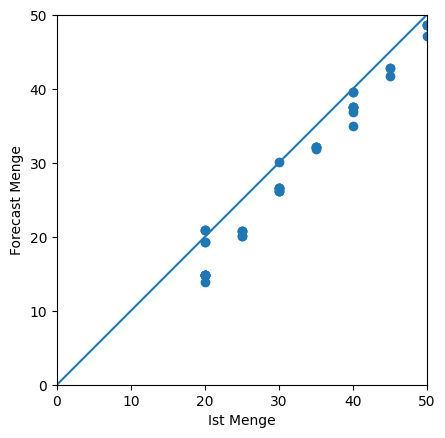

In [ ]:
# @title
graphPredictions(model, x, y, 0, 50)

In [ ]:
# Neuen Input definieren
new_inputs = {
    'Temperatur': [18, 21, 24, 21, 13],
    'Sondereffekt': [0, 0, 0, 0, 0],
    'Sonnenschein': [1, 1, 1, 1, 0],
    'Wochenende': [0, 0, 1, 1, 0],
    'Sonderoeffnungszeit': [0, 1, 1, 1, 0]
}

# DataFrame aus neuen Inputs erstellen
new_df = pd.DataFrame(new_inputs)

# Standardisieren der Temperatur in den neuen Daten
new_df['Temperatur'] = (new_df['Temperatur'] - numTempMean) / numTempStd

# Umwandeln der neuen Daten in einen Tensor
new_x = torch.tensor(new_df.values, dtype=torch.float, device=device)

# Vorhersagen für die neuen Daten machen
model.eval()
with torch.no_grad():
    new_predictions = model(new_x)

# Rück-Standardisieren der Vorhersagen
new_predictions = new_predictions * numMengeStd + numMengeMean

# Ausgabe der vorhergesagten Werte
print("Vorhergesagte Mengen:", new_predictions.cpu().numpy())



Vorhergesagte Mengen: [[227.71077]
 [239.14935]
 [266.04565]
 [243.95396]
 [ 84.39259]]
